In [9]:
!pip install torch torchvision opencv-python

In [10]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder

In [11]:
# 1. Load and preprocess the dataset
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root='data', transform=data_transforms)

In [12]:
# Splitting dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
# 2. Load the ResNet-50 model and fine-tune
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Assuming 2 classes: person1 and person2

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00012)

In [14]:
# Training loop (simplified)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100.*correct/total}%")

Epoch 1/10, Validation Loss: 0.3772573471069336, Accuracy: 69.56521739130434%
Epoch 2/10, Validation Loss: 0.036143265664577484, Accuracy: 100.0%
Epoch 3/10, Validation Loss: 0.0010136020136997104, Accuracy: 100.0%
Epoch 4/10, Validation Loss: 0.0004260838031768799, Accuracy: 100.0%
Epoch 5/10, Validation Loss: 0.0007670208578929305, Accuracy: 100.0%
Epoch 6/10, Validation Loss: 0.0025041871704161167, Accuracy: 100.0%
Epoch 7/10, Validation Loss: 0.00660051079466939, Accuracy: 100.0%
Epoch 8/10, Validation Loss: 0.014706545509397984, Accuracy: 100.0%
Epoch 9/10, Validation Loss: 0.025707362219691277, Accuracy: 100.0%
Epoch 10/10, Validation Loss: 0.039714131504297256, Accuracy: 95.65217391304348%


In [15]:
# 3. Save the trained model
torch.save(model.state_dict(), 'fine_tuned_resnet50.pth')

In [16]:
# 4. Real-time Classification using Webcam
model.load_state_dict(torch.load('fine_tuned_resnet50.pth'))


<All keys matched successfully>

In [17]:
!pip install opencv-python
import cv2

In [18]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
from PIL import Image
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    # Convert the frame from OpenCV's format to a PIL Image
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Preprocess the frame
    frame_transform = data_transforms(pil_image)
    frame_tensor = torch.unsqueeze(frame_transform, 0)

    # Make prediction
    with torch.no_grad():
        outputs = model(frame_tensor)
        _, predicted = outputs.max(1)
        label = "person1" if predicted.item() == 0 else "person2"

    # Display the result
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Webcam Classification', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [20]:
!pip install matplotlib



  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/c9/46/6cbaf20f5bd0e7c1d204b45b853c2cd317b303fada90245f2825ecca47de/matplotlib-3.7.2-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/a5/d6/80258c2759bd34abe267b5d3bc6300f7105aa70181b99d531283f7e7c79e/contourpy-1.1.0-cp39-cp39-win_amd64.whl.metadata
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/cd/b1/8ba85c3d50562438d5991f5698d46b66dcadd43d230c7ba72edbd0c96ce8/fonttools-4.42.0-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/153.7 kB ? eta -:--:--
     ------- ------------------------------- 30.7/153.7 kB 1.4 MB/s eta 0:00:01
     --------------------------- ---------- 112.6/153.7 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 153.7/153.7 kB 1.3 M

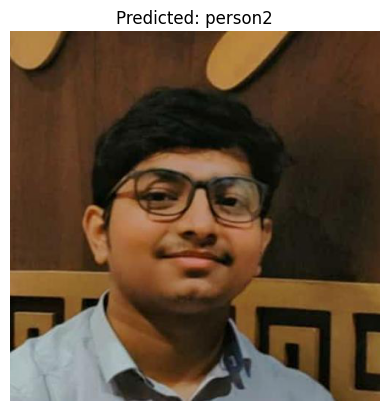

In [26]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Assuming 2 classes: person1 and person2
model.load_state_dict(torch.load('fine_tuned_resnet50.pth'))
model.eval()

def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = data_transforms(image)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)
        label = "person1" if predicted.item() == 0 else "person2"

    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.show()

# Test on a single image
image_path = "subhro.jpg"
predict_image(image_path)


In [27]:
!pip install opencv-python torch torchvision Pillow


In [28]:
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt

# Load the trained model
model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Assuming 2 classes: person1 and person2
model.load_state_dict(torch.load('fine_tuned_resnet50.pth'))
model.eval()

# Define the data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_frame(frame):
    # Convert the frame from OpenCV's format to a PIL Image
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Preprocess the frame
    frame_tensor = data_transforms(pil_image)
    frame_tensor = frame_tensor.unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        outputs = model(frame_tensor)
        _, predicted = outputs.max(1)
        label = "person1" if predicted.item() == 0 else "person2"
    
    return label

# Capture video feed from webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Predict the label for the current frame
    label = predict_frame(frame)

    # Display the result on the frame
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Real-time Classification', frame)

    # Exit the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [29]:
!pip install opencv-python torch torchvision Pillow


In [31]:
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50

# Load the trained model
model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Assuming 2 classes: person1 and person2
model.load_state_dict(torch.load('fine_tuned_resnet50.pth'))
model.eval()

# Define the data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def predict_frame(frame):
    # Detect faces in the frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # If no face is detected, return "other"
    if len(faces) == 0:
        return "other", frame

    # If a face is detected, classify it using the trained model
    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        pil_image = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        face_tensor = data_transforms(pil_image)
        face_tensor = face_tensor.unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            outputs = model(face_tensor)
            _, predicted = outputs.max(1)
            label = "person1" if predicted.item() == 0 else "person2"
        
        # Draw a bounding box around the detected face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        return label, frame

# Capture video feed from webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Predict the label for the current frame
    label, frame_with_bbox = predict_frame(frame)

    # Display the result on the frame
    cv2.putText(frame_with_bbox, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Real-time Classification', frame_with_bbox)

    # Exit the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [33]:
!pip install streamlit


  Obtaining dependency information for streamlit from https://files.pythonhosted.org/packages/20/fb/c52ddcedbb0cb142ab6f22b6d1ccee6162ade7d61ca139bc064168262ced/streamlit-1.25.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for altair<6,>=4.0 from https://files.pythonhosted.org/packages/b2/20/5c3b89d6f8d9938325a9330793438389e0dc94c34d921f6da35ec62095f3/altair-5.0.1-py3-none-any.whl.metadata
  Using cached blinker-1.6.2-py3-none-any.whl (13 kB)
  Obtaining dependency information for click<9,>=7.0 from https://files.pythonhosted.org/packages/1a/70/e63223f8116931d365993d4a6b7ef653a4d920b41d03de7c59499962821f/click-8.1.6-py3-none-any.whl.metadata
  Obtaining dependency information for pandas<3,>=1.3.0 from https://files.pythonhosted.org/packages/9a/f2/0ad053856debbe90c83de1b4f05915f85fd2146f20faf9daa3b320d36df3/pandas-2.0.3-cp39-cp39-win_amd64.whl.metadata
  Using cached Pillow-9.5.0-cp39-cp39-win_amd64.whl (2.5 MB)
  Obtaining dependency information for protobuf<5,>=3.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.24.0 which is incompatible.
tensorflow 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.24.0 which is incompatible.


In [34]:
!pip install torch torchvision
!pip install opencv-python
!pip install Pillow
!pip install numpy
!pip install streamlit torch torchvision opencv-python Pillow numpy

In [35]:
import streamlit as st
import cv2
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50

# Load the trained model
model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Assuming 2 classes: person1 and person2
model.load_state_dict(torch.load('fine_tuned_resnet50.pth'))
model.eval()

# Define the data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


def predict_image(image):
    # Convert PIL Image to OpenCV format
    opencv_image = np.array(image)[:, :, ::-1].copy()

    # Detect faces
    gray = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # If no face is detected, return "other"
    if len(faces) == 0:
        return "other", opencv_image

    for (x, y, w, h) in faces:
        face = opencv_image[y:y + h, x:x + w]
        pil_image = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        face_tensor = data_transforms(pil_image)
        face_tensor = face_tensor.unsqueeze(0)

        with torch.no_grad():
            outputs = model(face_tensor)
            _, predicted = outputs.max(1)
            label = "person1" if predicted.item() == 0 else "person2"

        # Draw bounding box
        cv2.rectangle(opencv_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(opencv_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return label, opencv_image


# Streamlit UI
st.title("Face Recognition App")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    label, opencv_image = predict_image(image)
    st.image(opencv_image, channels="BGR", use_column_width=True)
    st.write(f"Prediction: {label}")


2023-08-10 22:45:35.849 
  command:

    streamlit run C:\Users\Subhr\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [ ]:
!pip install streamlit-webrtc
!pip install streamlit --upgrade
!pip install streamlit-webrtc --upgrade
!streamlit run pytorch.py

In [3]:
!python streamlit.py